# Assignment 5: Network Models and Statistical Analysis

In [113]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import numpy as np

import matplotlib.pyplot as plt

from typing import Tuple, List, Dict, Union, Set
from sklearn.metrics.cluster import normalized_mutual_info_score
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import seaborn as sns
import random
import scipy.stats as stats

## Part 1: Structural Properties of the Graph

In [87]:
def load_football_graph() -> nx.Graph:    
    G = nx.read_gml("football.gml")
    return G    

### 1.1

In [88]:
def calculate_graph_statistics(G: nx.Graph) -> Dict[str, Union[float, List[int]]]:
    """
    Inputs:
    G: NetworkX graph object
    
    Returns:
    Dictionary of graph statistics
    
    """
    
    # Calculate the network diameter
    diameter = nx.diameter(G)
    
    # Calculate the characteristic path length (CPL)
    characteristic_path_length = nx.average_shortest_path_length(G)
    
    # Calculate the average clustering coefficient
    average_clustering_coefficient = nx.average_clustering(G)
    
    # Calculate the transitivity
    transitivity = nx.transitivity(G)
    
    # Calculate the assortativity
    assortativity = nx.degree_assortativity_coefficient(G)
    
    # Calculate the degree sequence
    degrees = []
    for _, degree in G.degree():
        degrees.append(degree)
    degree_sequence = sorted(degrees, reverse=True)
    
    # Return the dictionary that contains the above data.
    graph_statistics = {
        "diameter": diameter,
        "characteristic_path_length": characteristic_path_length,
        "average_clustering_coefficient": average_clustering_coefficient,
        "transitivity": transitivity,
        "assortativity": assortativity,
        "degree_sequence": degree_sequence
    }
    
    
    return graph_statistics

### 1.2

In [89]:
def sweep_louvain_resolutions(G: nx.Graph, min_resolution: int=1, max_resolution: int=10) -> Tuple[List[int], List[float]]:
    """
    Inputs:
    G: NetworkX graph object
    min_resolution : integer
    max_resolution : integer
    
    Returns:
    Tuple of list of resolutions and list of NMIs
    
    """
    
    # Find the fround choose of each node
    ground_truth = {}
    for node in G.nodes():
        ground_truth[node] = G.nodes[node]['value']
    
    # Generate 10 different resolution parameters from min_resolution to max_resolution
    resolutions = np.linspace(min_resolution, max_resolution, 10)
    
    nmis = []
    
    for resolution in resolutions:
        
        # Use Louvain algorithm to find the community partition
        # It will return a dictionary with key: value = node: community such as {0: 2, 1: 5, 2: 0,...}
        partition = community_louvain.best_partition(G, resolution=resolution)
        
        community_real = []
        community_pred = []
        
        for node in G.nodes():
            community_real.append(ground_truth[node])
            community_pred.append(partition[node])
        
        # Use normalized mutual information to compare the result of each partition 
        nmi = normalized_mutual_info_score(community_real, community_pred)
        nmis.append(nmi)
    
    return list(resolutions), nmis


def plot_nmi_vs_resolution(resolutions: List[int], nmis: List[float], save: bool=False) -> None:
    """
    Inputs:
    min_resolution : integer
    max_resolution : integer
    save: boolean
    
    Returns:
    None
    
    """
    
    plt.figure(figsize=(10, 6))
    plt.plot(resolutions, nmis, marker='o', linestyle='-', color='blue', linewidth=2)
    
    # Find the resolution with the highest NMI
    best_resolution_index = np.argmax(nmis)
    best_resolution = resolutions[best_resolution_index]
    best_nmi = nmis[best_resolution_index]
    
    # Highlight the best resolution
    plt.scatter(best_resolution, best_nmi, color='red', s=100, zorder=5)
    plt.annotate(f'Best: ({best_resolution:.2f}, {best_nmi:.4f})',
                xy=(best_resolution, best_nmi),
                xytext=(best_resolution+0.2, best_nmi+0.02),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    # Add titles and labels
    plt.title('Normalized Mutual Information vs Resolution Parameter', fontsize=14)
    plt.xlabel('Resolution Parameter', fontsize=12)
    plt.ylabel('Normalized Mutual Information (NMI)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add a horizontal line at the maximum NMI
    plt.axhline(y=best_nmi, color='gray', linestyle='--', alpha=0.5)
    
    # Adjust the y-axis to focus on the range of NMI values
    y_min = max(0, min(nmis) - 0.05)
    y_max = min(1, max(nmis) + 0.05)
    plt.ylim(y_min, y_max)
    
    plt.tight_layout()
    


    if save:
        plt.savefig('1_2_1.png')

    plt.show()

### 1.3

In [90]:
def calculate_best_partition(G: nx.Graph, resolutions: List[int], nmis: List[float]) -> Tuple[int, List[Set[str]]]:
    """
    Inputs:
    G: NetworkX graph object
    resolutions : a list of integer
    nmis :a list of float
    
    Returns:
    Tuple of resolution and partition
    
    """
    
    max_index_of_nmi = np.argmax(nmis)
    
    # Get the corresponding resolution
    best_resolution = resolutions[max_index_of_nmi]
    
    # Compute the best partition for the community
    community_best_partition = community_louvain.best_partition(G, resolution=best_resolution)
    
    # Get all of the unique communities from the selectted partition
    communities = set(community_best_partition.values())
    
    # For each community_id, find its corresponding nodes and save these nodes as a set.
    partition = []
    for community_id in communities:
        nodes = set()
        for node, best_comm_id in community_best_partition.items():
            if best_comm_id == community_id:
                nodes.add(str(node))
        partition.append(nodes)
    
    # Convert the resolution to int as per the function signature
    return int(best_resolution), partition


def plot_best_partition(G: nx.Graph, partition: List[str], save: bool=False) -> None:
    """
    Inputs:
    G: NetworkX graph object
    partition : List[str]
    save: boolean
    
    Returns:
    None
    
    """
    
    plt.figure(figsize=(16, 8))
    
    # Extract ground truth communities from node attributes
    ground_truth_dict = {node: G.nodes[node]['value'] for node in G.nodes()}
    
    # Convert ground truth dictionary to list of sets format
    unique_gt_communities = set(ground_truth_dict.values())
    ground_truth_partition = []
    for comm_id in unique_gt_communities:
        community_nodes = {node for node, gt_id in ground_truth_dict.items() if gt_id == comm_id}
        ground_truth_partition.append(community_nodes)
    
    # Set up the layout for both subplots
    pos = nx.spring_layout(G, seed=42)  # Same layout for both to make comparison easier
    
    # Plot ground truth communities
    plt.subplot(1, 2, 1)
    
    # Create a colormap for communities
    num_gt_communities = len(ground_truth_partition)
    gt_colors = cm.rainbow(np.linspace(0, 1, num_gt_communities))
    
    # Draw nodes colored by ground truth community
    for i, community in enumerate(ground_truth_partition):
        nx.draw_networkx_nodes(G, pos, 
                              nodelist=list(community),
                              node_color=[gt_colors[i]] * len(community),
                              node_size=100, 
                              alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    plt.title("Ground Truth Communities", fontsize=15)
    plt.axis('off')
    
    # Plot best partition communities
    plt.subplot(1, 2, 2)
    
    # Create a colormap for communities
    num_louvain_communities = len(partition)
    louvain_colors = cm.rainbow(np.linspace(0, 1, num_louvain_communities))
    
    # Draw nodes colored by Louvain community
    for i, community in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, 
                              nodelist=list(community),
                              node_color=[louvain_colors[i]] * len(community),
                              node_size=100, 
                              alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    plt.title(f"Louvain Communities (Best Partition)", fontsize=15)
    plt.axis('off')
    
    # Add a super title
    plt.suptitle("Community Structure Comparison: Ground Truth vs Louvain", fontsize=18)
    plt.tight_layout()


    if save:
        plt.savefig('1_2_2.png')

    plt.show()

### 1.4

In [91]:
def calculate_inter_community_density(G: nx.Graph, partition: list) -> Tuple[np.ndarray, List[int]]:
    """
    Inputs:
    G: NetworkX graph object
    partition : list
    
    Returns:
    Tuple of np array and List[int], intercommunity connection density matrix
    
    """
    
    # Calculate the number of communities
    community_num = len(partition)
    
    # Initialize the density matrix
    density_matrix = np.zeros((community_num, community_num))
    
    # Calculate the size of each community
    sizes = []
    for community in partition:
        sizes.append(len(community))
    
    # Map each node to its corresponding community_id
    node_to_community = {}
    for community_id, community in enumerate(partition):
        for node in community:
            node_to_community[node] = community_id
    
    # Calcuate the edge count by walking through all of the edges in the graph
    for u, v in G.edges(): 
        if str(u) in node_to_community and str(v) in node_to_community:
            comm_of_u = node_to_community[str(u)]
            comm_of_v = node_to_community[str(v)]
            
            density_matrix[comm_of_u, comm_of_v] += 1
            density_matrix[comm_of_v, comm_of_u] += 1 
    
    # Calculate densities based on the edge count
    for i in range(community_num):
        for j in range(community_num):
            if i == j:
                # Maximum number of possible edges within the community
                max_num_edges = sizes[i] * (sizes[i] - 1) / 2
                if max_num_edges > 0:  # Avoid division by zero
                    density_matrix[i, j] = density_matrix[i, j] / (max_num_edges * 2)
            else:
                # Maximum number of edges between communities
                max_num_edges = sizes[i] * sizes[j]
                if max_num_edges > 0:  # Avoid division by zero
                    density_matrix[i, j] = density_matrix[i, j] / (max_num_edges * 2)
    
    return density_matrix, sizes


def plot_p_matrix(p: np.ndarray, save: bool=False):
    """
    Inputs:
    p: np array, intercommunity connection density matrix
    save: boolean
    
    Returns:
    None
    """
    
    plt.figure(figsize=(12, 10))
    
    # Create a heatmap 
    ax = sns.heatmap(p, annot=True, cmap="YlGnBu", linewidths=0.4, cbar_kws={"label": "Connection Density"})
    
    # Set labels for the plot
    plt.title("Inter Community Connection Density Matrix")
    plt.xlabel("Community Id")
    plt.ylabel("Community Id")
    
    # Adjust tick labels to match community IDs (starting from 0)
    community_num = p.shape[0]
    
    # Create lists for tick positions and labels
    x_tick_positions = []
    y_tick_positions = []
    tick_labels = []

    # Calculate the poistion and record all of the labels
    for i in range(community_num):
        x_tick_positions.append(i + 0.5)
        y_tick_positions.append(i + 0.5)
        tick_labels.append(str(i))

    # Based on above calculations set the tick positions and labels
    ax.set_xticks(x_tick_positions)
    ax.set_yticks(y_tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    
    # Adjust layout
    plt.tight_layout()
    

    if save:
        plt.savefig('1_3.png')

    plt.show()

### 1.5

Run the code in the 1.5 cell. How does the resolution impact the NMI? Is the partition for the best NMI a good match to the ground truth? Justify your answer based on the visual plot and the NMI value itself.

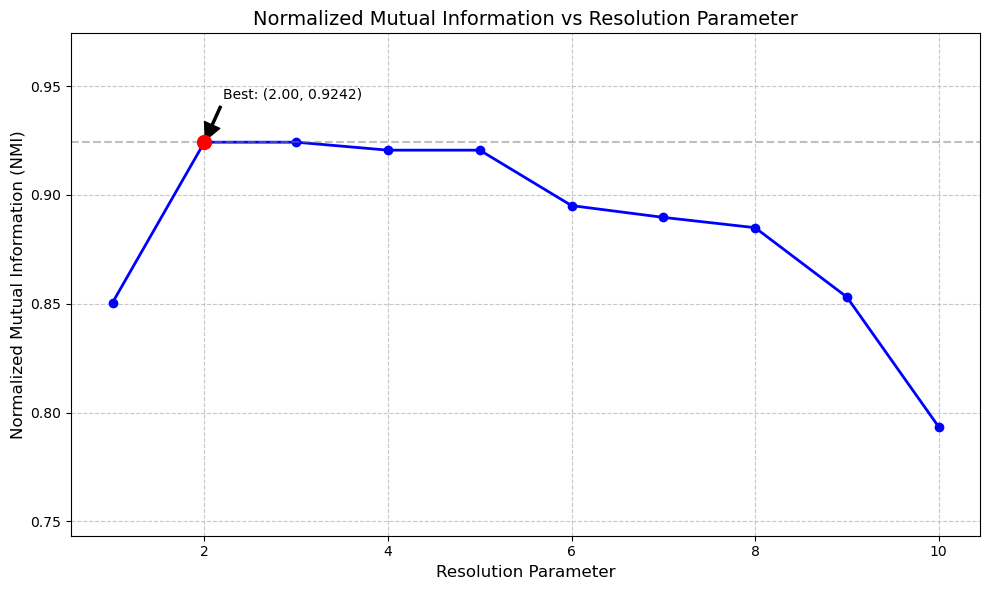

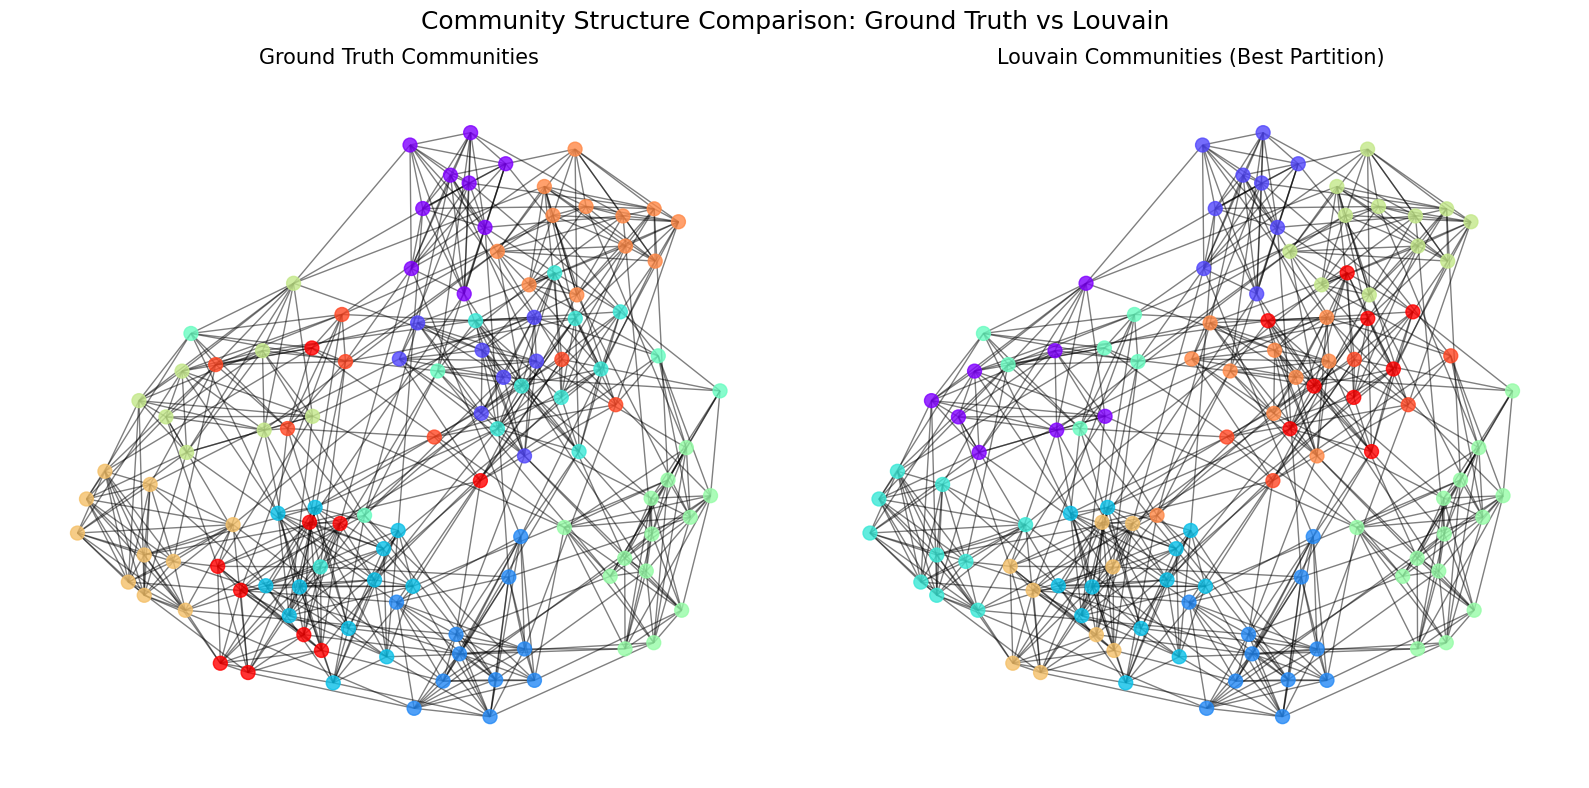

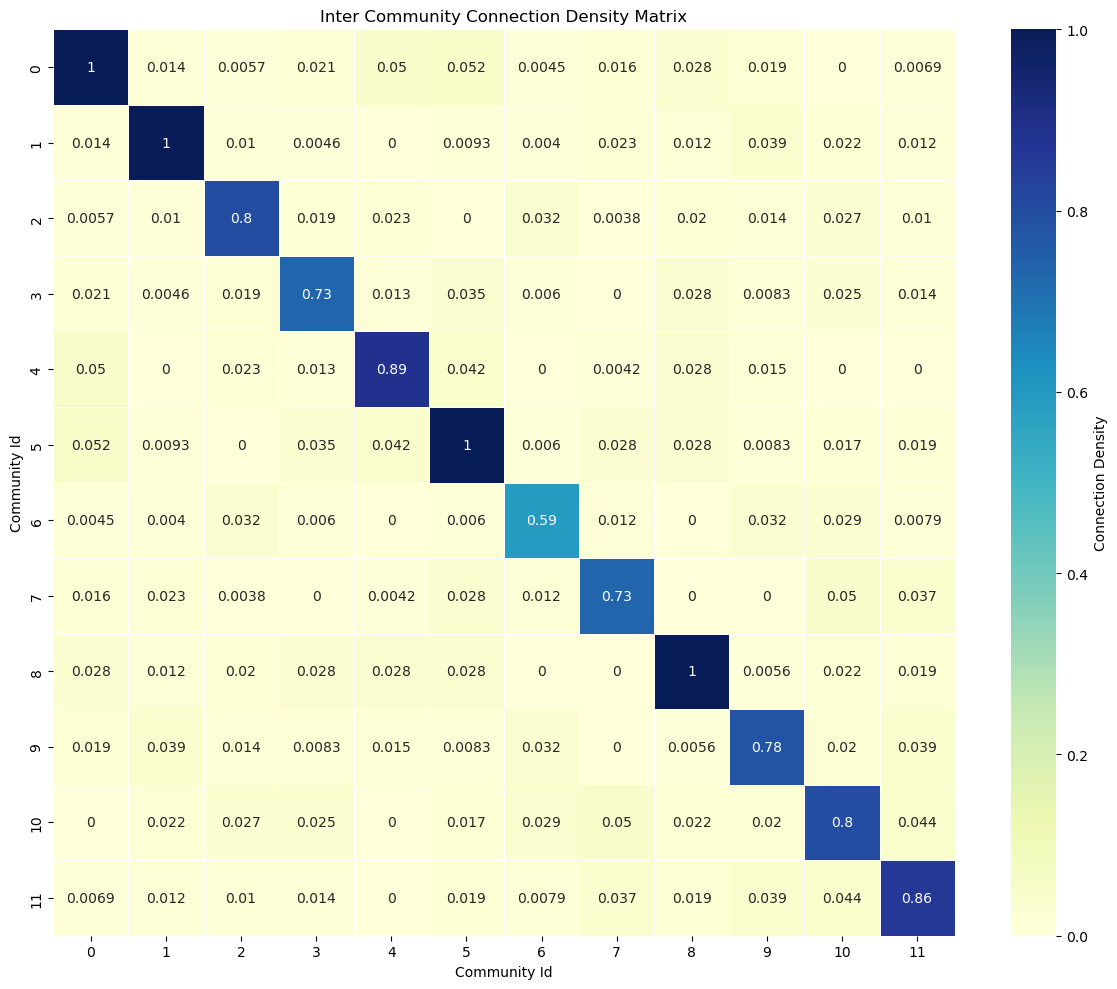

In [92]:
"""
1.5 cell
"""
G = load_football_graph()

# 1.1
graph_stats = calculate_graph_statistics(G)

# 1.2 
resolutions, nmis = sweep_louvain_resolutions(G)
best_resolution, partition = calculate_best_partition(G, resolutions, nmis)
plot_nmi_vs_resolution(resolutions, nmis)
plot_best_partition(G, partition)

# # 1.3
p, sizes = calculate_inter_community_density(G, partition)
plot_p_matrix(p)


### 1.5 Written Response

Answer:

## Part 2: Graph Generators
### 2.1

In [95]:
def generate_configuration_graphs(degree_sequence: List[int], n_graphs: int=100) -> List[nx.Graph]:
    """
    Inputs:
    degree_sequence: List[int]
    n_graphs: int
    
    Returns:
    a list of graph
    """
    
    graphs = []
    
    for i in range(n_graphs):
        
        # Generate the graph by using configuration model
        graph = nx.configuration_model(degree_sequence, create_using=nx.Graph())
        
        # Remove self-loops in the configuration model
        graph.remove_edges_from(nx.selfloop_edges(graph))
        
        graphs.append(graph)

    return graphs

def generate_sbm_graphs(p: np.ndarray, sizes: List[int], n_graphs: int=100) -> List[nx.Graph]:
    """
    Inputs:
    p: np.ndarray, element (r,s) gives the density of edges going from the nodes of group r to nodes of group s.
    degree_sequence: List[int]
    n_graphs: int
    
    Returns:
    a list of graph
    """
    
    graphs = []
    
    for i in range(n_graphs):
        
        # Generate the graph by using stochastic block model
        graph = nx.stochastic_block_model(sizes, p)
        
        graphs.append(graph)
    
    return graphs

### 2.2

In [122]:
def calculate_edge_probability(dendrogram: nx.DiGraph) -> Dict[str, Dict[str, float]]:
    """
    Inputs:
    dendrogram: NetworkX graph object    
    
    Returns:
    a dictionary of edge probabilities between all pairs of leaf nodes.
    """
    
    # Find all of the leaf nodes 
    leaf_nodes = []
    for node in dendrogram.nodes():
        if dendrogram.out_degree(node) == 0:
            leaf_nodes.append(node)

    # Initialize the edge probability dictionary. E.g., 
    # edge_probs = {
    #     "A": {
    #         "B": 0.7,
    #         "C": 0.3,
    #         "D": 0.2
    #     },
    #     "B": {
    #         "A": 0.7,
    #         "C": 0.5,
    #         "D": 0.4
    #     },
    #}
    edge_probs = {}
    for node in leaf_nodes:
        edge_probs[node] = {}
    
    # Function to find the lowest common ancestor (LCA) of two leaf nodes
    def find_lca(node1: str, node2: str) -> str:
        # Get all ancestors of each node (including the node itself)
        ancestors1 = set()
        current = node1
        while current in dendrogram.nodes():
            ancestors1.add(current)
            # Get predecessors (parents in directed graph)
            parents = list(dendrogram.predecessors(current))
            if not parents:
                break
            current = parents[0]
        
        # Find LCA by traversing up from node2 until finding a common ancestor
        current = node2
        while current in dendrogram.nodes():
            if current in ancestors1:
                return current
            parents = list(dendrogram.predecessors(current))
            if not parents:
                break
            current = parents[0]
        
        return None
    
    # Calculate the probability between leaf nodes
    for index, leaf_node_1 in enumerate(leaf_nodes):
        for leaf_node_2 in leaf_nodes[index+1:]:  
            
            # Cacluate the lowest common ancestor between two leaf nodes
            lca = find_lca(leaf_node_1, leaf_node_2)
            
            # Get the probability from the LCA node attribute
            if lca is not None and 'p' in dendrogram.nodes[lca]:
                prob = dendrogram.nodes[lca]['p']
            else:
                prob = 0.0 
            
            # Store the probability in both directions (undirected graph)
            edge_probs[leaf_node_1][leaf_node_2] = prob
            edge_probs[leaf_node_2][leaf_node_1] = prob
    
    return edge_probs

def generate_graph_from_prob(edge_probs: Dict[str, Dict[str, float]]) -> nx.Graph:
    """
    Inputs:
    edge_probs: a dictionary of edge probabilities between all pairs of leaf nodes.
    
    Returns:
    H: NetworkX graph object
    """
    
    H = nx.Graph()
    
    # Add all nodes to the graph
    H.add_nodes_from(edge_probs.keys())
    
    # Generate edges based on probabilities
    for node1 in edge_probs:
        for node2, prob in edge_probs[node1].items():
            # Skip if we've already processed this pair (to avoid duplicates)
            if node1 >= node2:
                continue
            
            # Generate a random number and create edge if it's less than probability
            if random.random() < prob:
                H.add_edge(node1, node2)
    
    return H

def generate_hrg_graphs(edge_probs: Dict[str, Dict[str, float]], n_graphs: int=100) -> List[nx.Graph]:
    """
    Inputs:
    edge_probs: a dictionary of edge probabilities between all pairs of leaf nodes.
    n_graphs: int
    
    Returns:
    a list of NetworkX graph object
    """
    
    graphs = []
    
    for i in range(n_graphs):
        
        # Generate the graph based on edge probabilities
        graph = generate_graph_from_prob(edge_probs)
        
        graphs.append(graph)
    
    return graphs

### 2.3

In [123]:
def calculate_generated_statistics(graphs: List[nx.Graph]) -> Dict[str, list]:
    """
    Inputs:
    graphs: a list of NetworkX graph object
    
    Returns:
    a dictionary of graph statistics
    """
    # Initialize dictionary to store results
    graph_statistics = {
        "diameter": [],
        "characteristic_path_length": [],
        "average_clustering_coefficient": [],
        "transitivity": [],
        "assortativity": [],
        "degree_sequence": []
    }
    
    # Calculate statistics for each graph
    for graph in graphs:
        # If the graph is not connected, use the largest connected component
        if not nx.is_connected(graph):
            graph = graph.subgraph(max(nx.connected_components(graph), key=len))
        
        # Calculate diameter
        diameter = nx.diameter(graph)
        graph_statistics["diameter"].append(diameter)
        
        # Calculate average shortest path length (characteristic path length)
        cpl = nx.average_shortest_path_length(graph)
        graph_statistics["characteristic_path_length"].append(cpl)
        
        # Calculate average clustering coefficient
        avg_clustering = nx.average_clustering(graph)
        graph_statistics["average_clustering_coefficient"].append(avg_clustering)
        
        # Calculate transitivity (global clustering coefficient)
        transitivity = nx.transitivity(graph)
        graph_statistics["transitivity"].append(transitivity)
        
        # Calculate degree assortativity coefficient
        try:
            assortativity = nx.degree_assortativity_coefficient(graph)
        except:
            # In case of error (e.g., for graphs with no variation in degree)
            assortativity = float('nan')
        graph_statistics["assortativity"].append(assortativity)
        
        # Store degree sequence
        degree_sequence = [d for _, d in graph.degree()]
        graph_statistics["degree_sequence"].append(degree_sequence)
    
    return graph_statistics


def compare_generated_to_ground_truth(ground_truth_features: Dict[str, float], generated_features: Dict[str, List[float]]) -> Dict[str, float]:
    """
    Inputs:
    ground_truth_features: a dictionary of graph statistics
    generated_features: a dictionary of graph statistics
    
    Returns:
    a dictionary of one-sample t-test
    """
    p_vals = {}
    
    # Perform one-sample t-test for each statistic
    for stat in ground_truth_features:
        # Skip degree_sequence as it's not a scalar value suitable for t-test
        if stat == "degree_sequence":
            continue
            
        if stat in generated_features:
            # Remove any NaN values that might cause problems in the t-test
            sample = []
            for x in generated_features[stat]:
                # Check if x is a scalar (not a list or array)
                if np.isscalar(x):
                    if not np.isnan(x):
                        sample.append(x)
            
            # Run t-test if we have samples
            if len(sample) > 0:
                t_stat, p_value = stats.ttest_1samp(sample, ground_truth_features[stat])
                p_vals[stat] = p_value
            else:
                p_vals[stat] = float('nan')
    
    return p_vals


def plot_graph_statistics(graph_statistics: List[Dict[str, list]], save: bool=False) -> None:
    """
    Inputs:
    graph_statistics: a dictionary of graph statistics
    
    Returns:
    None
    """
    # Create default model names
    model_names = [f"Model {i+1}" for i in range(len(graph_statistics))]
    
    # Get the statistic names from the first dictionary
    stats_names = ["diameter", "characteristic_path_length", "average_clustering_coefficient", 
                  "transitivity", "assortativity"]
    
    # Set up the figure with subplots
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    fig.suptitle("Comparison of Network Statistics Across Different Graph Models", fontsize=16)
    
    # Create boxplots for each statistic
    for i, stat in enumerate(stats_names):
        # Prepare data for boxplot
        data = [model_stats[stat] for model_stats in graph_statistics]
        
        # Create boxplot in the appropriate subplot
        bp = axes[i].boxplot(data, labels=model_names)
        
        # Set title and labels
        axes[i].set_title(stat.replace("_", " ").title())
        axes[i].set_ylabel("Value")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()


    if save:
        plt.savefig('2_3.png')

    plt.show()

### 2.4
This code reruns some calculations from 1.5 to avoid errors, but you can comment it out if you already have the values stored in memory.

Configuration Model t-test
{'diameter': 1.279277352884499e-08, 'characteristic_path_length': 2.1847288198258815e-142, 'average_clustering_coefficient': 2.097935701715695e-169, 'transitivity': 1.3271859676908892e-171, 'assortativity': 4.846585387056144e-58}
Stochastic Block Model t-test
{'diameter': 1.2682445715878558e-47, 'characteristic_path_length': 4.2419372801503384e-75, 'average_clustering_coefficient': 1.039236942038414e-85, 'transitivity': 5.966916185287864e-81, 'assortativity': 6.461925105084353e-16}
HRG Model t-test
{'diameter': 0.0012748384719836728, 'characteristic_path_length': 1.181532761771874e-07, 'average_clustering_coefficient': 5.612829420276337e-41, 'transitivity': 0.006363787043916134, 'assortativity': 2.2406066331637176e-41}


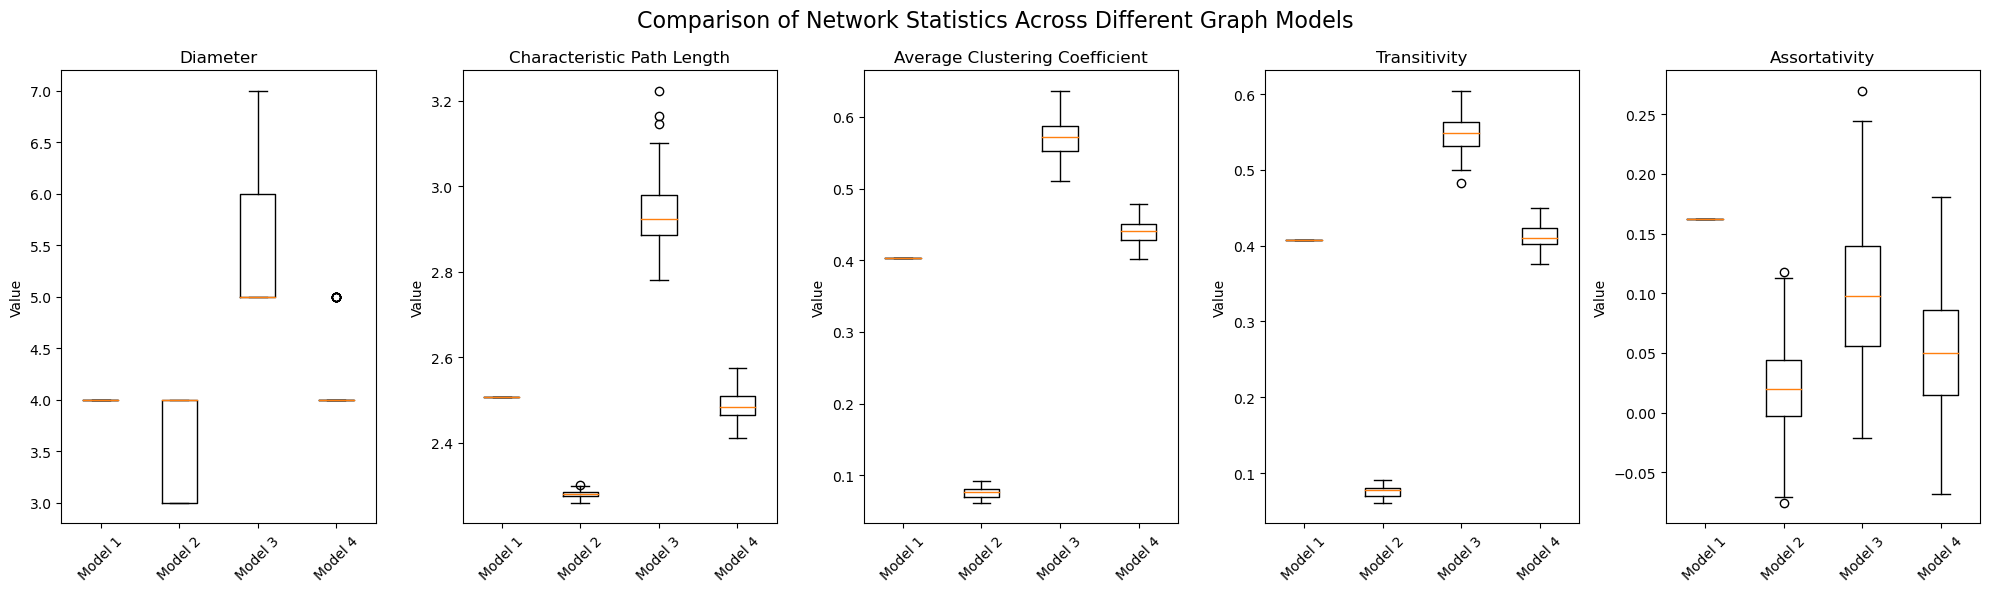

In [124]:
G = load_football_graph()
graph_stats = calculate_graph_statistics(G)

# Configuration Model
config_graphs = generate_configuration_graphs(graph_stats['degree_sequence'])

# Stochastic Block Model
resolutions, nmis = sweep_louvain_resolutions(G)
best_resolution, partition = calculate_best_partition(G, resolutions, nmis)
p, sizes = calculate_inter_community_density(G, partition)
sbm_graphs = generate_sbm_graphs(p, sizes)

# Hierarchical Random Graph Model
dendrogram = nx.read_gml("football-hrg.gml")
edge_probs = calculate_edge_probability(dendrogram)
hrg_graphs = generate_hrg_graphs(edge_probs)

# Calculating network characteristic statistics
config_stats = calculate_generated_statistics(config_graphs)
sbm_stats = calculate_generated_statistics(sbm_graphs)
hrg_stats = calculate_generated_statistics(hrg_graphs)

# Hypothesis Test Stats
print('Configuration Model t-test')
print(compare_generated_to_ground_truth(graph_stats, config_stats))

print('Stochastic Block Model t-test')
print(compare_generated_to_ground_truth(graph_stats, sbm_stats))

print('HRG Model t-test')
print(compare_generated_to_ground_truth(graph_stats, hrg_stats))

plot_graph_statistics([graph_stats, config_stats, sbm_stats, hrg_stats])

### 2.4 Written Response

Answer: 

## Part 3: Slashdot Network

In [ ]:
def load_slashdot_graph() -> nx.Graph:
    # import "slashdot.txt"
    G = nx.read_edgelist("slashdot.txt", delimiter="\t", create_using=nx.DiGraph)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

### 3.1

In [ ]:
def estimate_network_size(G, sample_sizes: List[int]=[500, 1000, 2000, 5000, 10000], n_iter: int=1000) -> Dict[str, List[int]]:
    """
    Inputs:
    G: NetworkX graph object
    sample_sizes: List[int]
    n_iter: int

    Returns:
    a dictionary where key is the sample size and the value is a list of the estimated network sizes for each trial
    """


    return results

def plot_estimate_histogram(estimated_sizes: List[int], true_size: int, save: bool=False) -> None:
    """
    Inputs:
    estimated_sizes: List[int]
    true_size: int
    save:boolean

    Returns:
    None
    """


    if save:
        plt.savefig('3_1_1.png')

    plt.show()

def plot_sample_size_error(results: Dict[str, List[int]], true_size: int,
                           sample_sizes: List[int]=[500, 1000, 2000, 5000, 10000], save: bool=False) -> None:
    """
    Inputs:
    results: Dict[str, List[int]]
    true_size: int
    sample_sizes: List[int]
    save:boolean

    Returns:
    None
    """


    if save:
         plt.savefig('3_1_2.png')

    plt.show()


### 3.2

In [ ]:
def estimate_edges(G: nx.Graph, n_sample: int=5000, n_iter: int=100) -> List[int]:
    """
    Inputs:
    G: NetworkX graph object
    n_sample: int
    n_iter: int

    Returns:
    a list of estimated_edges
    """


    return estimated_edges

def plot_edge_estimate_distribution(estimated_edges: List[int], true_edges: int, save: bool=False) -> None:
    """
    Inputs:
    estimated_edges: List[int]
    true_edges: int
    save: boolean

    Returns:
    None
    """


    if save:
        plt.savefig('3_2.png')

    plt.show()

### 3.3

In [ ]:
G = load_slashdot_graph()

network_size_estimates = estimate_network_size(G)

plot_estimate_histogram(network_size_estimates[2000], len(G.nodes()))
plot_sample_size_error(network_size_estimates, len(G.nodes()))

edge_estimates = estimate_edges(G)
plot_edge_estimate_distribution(edge_estimates, len(G.edges()))



### 3.3 Written Response

Answer: